#### Import library

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, regexp_tokenize
import numpy as np
import time
from sklearn.cluster import KMeans
from tqdm import tqdm

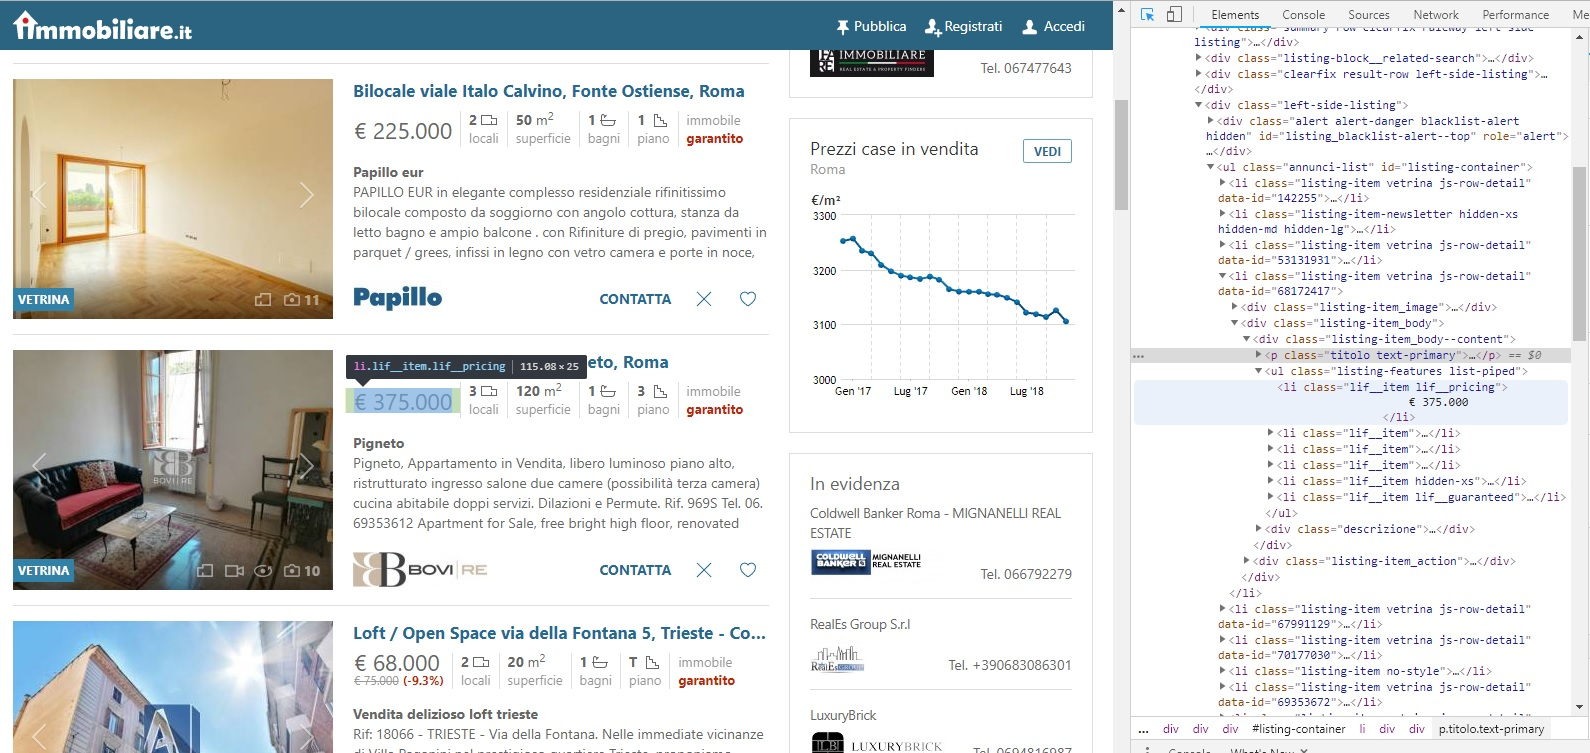

## Parsing page with BeautifulSoup

Get data from website and create a BeautifulSoup class to parse document

In [ ]:
#create lists where store the data
title=[]
price=[]
n_room=[]
mq=[]
n_bathroom=[]
plan=[]
desc=[]
i=1
#iterate to take data from different page
for num in tqdm(range(1,1728)):
    url = str('www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag='+str(1))
    r = requests.get('https://' +url)
    data = r.text
    soup = BeautifulSoup(data,'html.parser')

    #iterate on the main class which contain all the data 
    for announcement in tqdm(soup.find_all('div', class_='listing-item_body--content')):
        #find all 'li' class which contain the data that we want and put them on the lists
        feature = announcement.find_all('li')
        if len(feature)>=6:
            #filter word on price
            feature_price = feature[0].text.strip()
            if ('PREZZO SU RICHIESTA' in feature_price )== True:
                break
            elif('%' in feature_price) == True:
                feature_price = feature_price.replace('.','').replace('€','').replace(' ','')
                price.append(feature_price[-19:-12])
            else:
                feature_price = feature_price.replace('.','').replace('€','').replace(' ','')
                price.append(feature_price)
            feature_n_room = feature[1].text[0]
            n_room.append(feature_n_room)
            feature_mq = feature[2].text[0:-12].replace('\xa0','')
            mq.append(feature_mq)
            feature_n_bathroom = feature[3].text[0:-5].replace('+','').replace('\xa0','')
            n_bathroom.append(feature_n_bathroom)
            feature_plan = feature[4].text[0:-7].strip()
            #check if there is a character inside plan data, if yes pop last element in the others lists to mantain dimension
            if feature_plan.isalpha()==True:
                #title.pop()
                price.pop()
                n_room.pop()
                mq.pop()
                n_bathroom.pop()
                i+=0

            else:    
                plan.append(feature_plan)

                #find <a element where <href is present
                link=announcement.find('a', href=True)
                #check to solve the problem where the <href didn't have the complete link
                if ('https://' in link['href'])==True:
                    ann=requests.get(link['href'])
                else:
                    ann=requests.get('https://www.immobiliare.it'+link['href'])
                data1 = ann.text
                #create another bs4 element to access in the specific link and take commplete text from announcement
                soup1 = BeautifulSoup(data1,'html.parser')
                #access to link and take complete text
                a=soup1.find('div', attrs={'role':'contentinfo'}).text.strip()
                desc.append(a)
                title.append('announcement_'+str(i))
                i+=1


    time.sleep(1)

            

In [ ]:
print(len(title))
print(len(price))
print(len(n_room))
print(len(mq))
print(len(n_bathroom))
print(len(plan))
print(len(desc))

oNow we store the data in a pandas DataFrame

In [ ]:
table=pd.DataFrame({'Annuncio':title,
                    'Prezzo':price,
                    'Camere':n_room,
                    'Superficie':mq,
                    'Bagni':n_bathroom,
                    'Piano':plan})
#used to remove a \n inside "Piano" coloumn
table =table.set_index('Annuncio')
table=table.replace({r'\n': '',r'\+' : '',r'\xa0': ''}, regex=True)
table.head(5)

Take all the announcement from page

In [ ]:
#only see if the dataframe is the data are correct, then i remove this
annuncio=pd.DataFrame({'Annuncio':desc})
annuncio

Function to preprocess all text in the announcement

In [ ]:
def preprocess(text):
    text = text.lower()
    # removing '\n'
    text = text.replace('\\n', ' ')
    # removing punctuation
    tokenizer = regexp_tokenize(text, "[\w\$]+")
    # filter the non stopwords
    filtered = [w for w in tokenizer if not w in stopwords.words('italian')]
    ps = PorterStemmer()
    # removing the stem
    filtered = [ps.stem(word) for word in filtered]
    return filtered

Pre process all the announcement and put in a list

In [ ]:
processed_list=[]
for i in desc:
    processed_list.append(preprocess(i))    

In [ ]:
len(processed_list)

we have a list of word processed, now i convert it to a list of string

In [ ]:
b=[' '.join(i) for i in processed_list]

In [ ]:
len(b)

In [ ]:
ren=[int(i) for i in range(1,len(b)+1)]

In [ ]:
#N.B.need to find how to increse the docId in relation of document!!!!!!!!!
#creating dataframe with wordId and all text from the announcement processed
df1 = pd.DataFrame({'wordId': ren, 
               'parole': b})

we have used pandas and numpy to compute Tf-IDF in all dataframe

In [ ]:
# Tokenize and generate count vectors
word_vec = df1.parole.apply(str.split).apply(pd.value_counts).fillna(0)
# Compute term frequencies
tf = word_vec.divide(np.sum(word_vec, axis=1), axis=0)
# Compute inverse document frequencies
idf = np.log10(len(tf) / word_vec[word_vec > 0].count())
# Compute TF-IDF vectors
tfidf = np.multiply(tf, idf.to_frame().T)
#L2 (Euclidean) normalization
l2_norm = np.sum(np.sqrt(tfidf), axis=1)
#Normalized TF-IDF vectors
tfidf_norm = (tfidf.T / l2_norm).T
#put in a dataframe
#second_mat=pd.DataFrame(tfidf_norm)
#word_column=['word_'+str(i) for i in range(1,len(second_mat.columns)+1) ]
#second_mat.columns=word_column
#second_mat=second_mat.set_index(table.index)
#second_mat.head(10)


In [ ]:
word_vec = df1.parole.apply(str.split).apply(pd.value_counts)#.fillna(0)

In [ ]:
word_vec

In [ ]:
len(tfidf_norm)

In [ ]:
second_mat=pd.DataFrame(tfidf_norm)

In [ ]:
second_mat

### Saving data to csv

In [ ]:
second_mat.to_csv(r'C:\Users\Daniele\Desktop\Matrix_TfIdf.csv')
table.to_csv(r'C:\Users\Daniele\Desktop\Matrix.csv')

# Clustering

In [ ]:
b=pd.read_csv(r'C:\Users\Daniele\Desktop\Matrix.csv')
table=b
table=table.set_index(['Annuncio'])
table.head(10)

In [ ]:
a=pd.read_csv(r'C:\Users\Daniele\Desktop\Matrix_TfIdf.csv')
second_mat=a
second_mat=second_mat.set_index(['Annuncio'])
second_mat.head(10)

In [ ]:
# Convert DataFrame to matrix
dataset_array =second_mat.values
dataset_array1=table.values
# Using sklearn
km =KMeans(n_clusters=5, init='k-means++', tol=0.0001).fit(dataset_array)
km1=KMeans(n_clusters=5, init='k-means++', tol=0.0001).fit(dataset_array1)
# Get cluster assignment labels
labels = km.labels_
labels1 = km1.labels_
#put the result of cluster in a dataframe
results = pd.DataFrame([second_mat.index,labels]).T
results1 = pd.DataFrame([table.index,labels]).T

In [ ]:
final_result=pd.merge(results, results1, on=0)
final_result

In [ ]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection / union)

In [ ]:
cluster1=km.cluster_centers_
cluster2=km1.cluster_centers_    


In [ ]:
km1.labels_

In [ ]:
for i in range(len(cluster1)):
    print(jaccard_similarity(cluster1[i],cluster2[i]))


# Find the duplicates!

In [ ]:
len(km1.cluster_centers_)